In [55]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.adapt(minimum=28, maximum=136)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [56]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.1:35353 Dashboard: http://172.30.100.1:46706/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [57]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


In [58]:
#params

tous_les_plots_gridT=True
tous_les_plots_flxT=True

In [59]:
config='EU36'
case='MPC001'
freq='1d'
year='2010'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

In [60]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [61]:
def compute_EKE(u,v,u2mean,v2mean):
    ua=0.5*((u2mean-u*u)+(u2mean.shift(x=-1)-u.shift(x=-1)*u.shift(x=-1)))
    va=0.5*((v2mean-v*v)+(v2mean.shift(y=-1)-v.shift(y=-1)*v.shift(y=-1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [62]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_monthly(var,mask,vmin,vmax,cmap,title,figfile):
    fig, axes = plt.subplots(3,4,figsize=(30,20))
    axes = axes.ravel()
    for m in np.arange(1,13):
        if m < 10:
            month='0'+str(m)
        else:
            month=str(m)
        if m in [1,3,5,7,8,10,12]:
            dayf='31'
        elif m == 2:
            dayf='28'
        else:
            dayf='30'
        ax=axes[m-1]
        var.sel(time_counter=slice('2010-'+month+'-01','2010-'+month+'-'+dayf)).mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
        ax.set_title(month_name[m])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig(config+'-'+case+'y'+str(year)+'.1m_'+figfile+'.png')

In [89]:
def plot_annual(var,mask,vmin,vmax,cmap,title,figfile):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    fig.suptitle('Annual mean of '+str(title))
    plt.savefig(config+'-'+case+'_y'+str(year)+'.1y_'+figfile+'.png')    

In [64]:
filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))

In [65]:
filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))

In [66]:
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})

In [67]:
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})

In [68]:
dsU

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthu: 75, time_counter: 317, x: 732, y: 1718)
Coordinates:
    nav_lat               (y, x) float32 32.741238 32.741158 ... -1.0 -1.0
    nav_lon               (y, x) float32 -17.140152 -17.112343 ... -1.0 -1.0
  * depthu                (depthu) float32 0.50576 1.5558553 ... 5902.0576
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(317,), chunksize=(1,)>
  * time_counter          (time_counter) datetime64[ns] 2010-01-01T12:00:00 ... 2010-11-13T12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (time_counter, depthu, axis_nbounds) float32 dask.array<shape=(317, 75, 2), chunksize=(1, 1, 2)>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(317, 2), chunksize=(1, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(317, 2), chunksize=(1, 2)>
    e3u                   (time_co

In [69]:
u=dsU.vozocrtx

In [70]:
v=dsV.vomecrty

In [71]:
u2=u*u

In [72]:
v2=v*v

In [73]:
u2mean=u2.mean(dim='time_counter')

In [74]:
v2mean=v2.mean(dim='time_counter')

In [75]:
ua=0.5*((u2mean-u*u)+(u2mean.shift(x=-1)-u.shift(x=-1)*u.shift(x=-1)))
va=0.5*((v2mean-v*v)+(v2mean.shift(y=-1)-v.shift(y=-1)*v.shift(y=-1)))


In [76]:
ua

<xarray.DataArray 'vozocrtx' (depthu: 75, y: 1718, x: 732, time_counter: 317)>
dask.array<shape=(75, 1718, 732, 317), dtype=float32, chunksize=(1, 1000, 700, 1)>
Coordinates:
    nav_lat        (y, x) float32 32.741238 32.741158 32.741077 ... -1.0 -1.0
    nav_lon        (y, x) float32 -17.140152 -17.112343 -17.084534 ... -1.0 -1.0
  * depthu         (depthu) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(317,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T12:00:00 ... 2010-11-13T12:00:00
Dimensions without coordinates: y, x

In [77]:
va

<xarray.DataArray 'vomecrty' (depthv: 75, y: 1718, x: 732, time_counter: 317)>
dask.array<shape=(75, 1718, 732, 317), dtype=float32, chunksize=(1, 1000, 700, 1)>
Coordinates:
    nav_lat        (y, x) float32 32.753014 32.752934 32.75285 ... -1.0 -1.0
    nav_lon        (y, x) float32 -17.154009 -17.1262 -17.09839 ... -1.0 -1.0
  * depthv         (depthv) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(317,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T12:00:00 ... 2010-11-13T12:00:00
Dimensions without coordinates: y, x

In [78]:
uat=ua.rename({'depthu':'deptht'})

In [79]:
vat=va.rename({'depthv':'deptht'})

In [80]:
eke=uat+vat

JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending


JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending


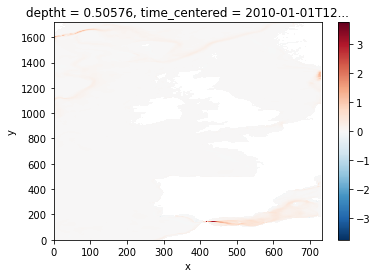

In [84]:
eke[0,:,:,0].plot()

JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called w

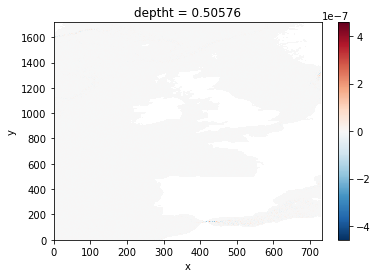

In [86]:
eke[0,:,:].mean(dim='time_counter').plot()

JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending


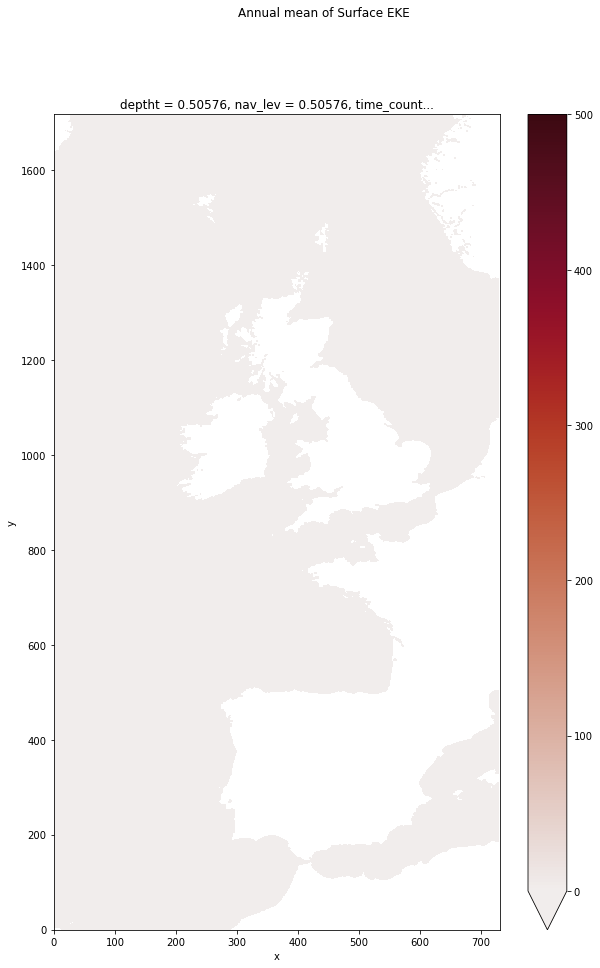

In [97]:
mask=dsmask.tmask[0]
plot_annual(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf')

In [100]:
truc=eke[0,:,:].mean(dim='time_counter')

In [108]:
print(truc[600:800,100:200].values)

JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending


[[ 1.9977897e-10  8.2261933e-11  2.5853750e-10 ...  1.8802727e-10
   1.8802727e-10 -9.4013637e-11]
 [ 2.3503409e-11 -5.8758523e-12 -9.4013637e-11 ... -9.4013637e-11
   2.8204092e-10 -9.4013637e-11]
 [ 1.9977897e-10  2.0565483e-10  1.8508935e-10 ... -1.8802727e-10
  -1.8802727e-10 -4.7006815e-10]
 ...
 [-1.8802727e-10  3.7605455e-10  1.2221772e-09 ... -1.6452387e-10
  -1.2926875e-10 -1.2926875e-10]
 [-5.6408184e-10 -1.8802727e-10  9.4013630e-10 ...  8.2261933e-11
  -1.8215142e-10  0.0000000e+00]
 [-1.8802727e-10  3.7605455e-10 -9.4013637e-11 ...  2.0271690e-10
  -1.0576534e-10  7.0510230e-11]]


In [94]:
mask

<xarray.DataArray 'tmask' (nav_lev: 75, y: 1718, x: 732)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int8)
Coordinates:
  * nav_lev       (nav_lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_counter  float64 0.0
Dimensions without coordinates: y, x

In [81]:
if plot_eke_annual == True:
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU)
    dsV=xr.open_mfdataset(filesV)
    u=dsU.vozocrtx
    v=dsV.vomecrty
    mask=dsmask.tmask[0]
    u2=u*u
    v2=v*v
    u2mean=u2.mean(dim='time_counter')
    v2mean=v2.mean(dim='time_counter')
    eke=compute_EKE(u,v,u2mean,v2mean)
    plot_annual(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf')
    plot_monthly(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf')

NameError: name 'plot_eke_annual' is not defined

JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
